# Imports

In [205]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.append(os.path.abspath(".."))
from utils import apply_thousand_separator

# Data load

In [206]:
df = pd.read_csv("../data/nypd-motor-vehicle-collisions-cleaned.csv", low_memory=False)

In [207]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1217957 entries, 0 to 1217956
Data columns (total 30 columns):
 #   Column                         Non-Null Count    Dtype 
---  ------                         --------------    ----- 
 0   ACCIDENT DATE                  1217957 non-null  object
 1   ACCIDENT TIME                  1217957 non-null  object
 2   BOROUGH                        1217957 non-null  object
 3   ZIP CODE                       847250 non-null   object
 4   LATITUDE                       1217957 non-null  object
 5   LONGITUDE                      1217957 non-null  object
 6   LOCATION                       1217957 non-null  object
 7   ON STREET NAME                 1217957 non-null  object
 8   CROSS STREET NAME              1217957 non-null  object
 9   OFF STREET NAME                1217957 non-null  object
 10  NUMBER OF PERSONS INJURED      1217957 non-null  int64 
 11  NUMBER OF PERSONS KILLED       1217957 non-null  int64 
 12  NUMBER OF PEDESTRIANS INJURE

In [208]:
df["BOROUGH"].unique()

array(['QUEENS', 'BROOKLYN', 'MANHATTAN', 'BRONX', 'STATEN ISLAND',
       'UNKNOWN'], dtype=object)

# Most dangerous accident factors in each New York borough

In [209]:
df_factors = df.copy()

In [210]:
columns = ["BOROUGH","NUMBER OF PERSONS INJURED","NUMBER OF PERSONS KILLED","CONTRIBUTING FACTOR VEHICLE 1",
           "CONTRIBUTING FACTOR VEHICLE 2","CONTRIBUTING FACTOR VEHICLE 3","CONTRIBUTING FACTOR VEHICLE 4", 
           "CONTRIBUTING FACTOR VEHICLE 5", "COLLISION_ID"]

In [211]:
df_factors = df_factors[columns]

In [212]:
df_factors.head()

,BOROUGH,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID
0,QUEENS,0,0,passing too closely,unknown,unknown,unknown,unknown,4184637
1,BROOKLYN,0,0,passing too closely,unknown,unknown,unknown,unknown,4195773
2,MANHATTAN,1,0,driver inattention/distraction,unknown,unknown,unknown,unknown,4202457
3,BRONX,0,0,unknown,unknown,unknown,unknown,unknown,4198749
4,MANHATTAN,1,0,driver inattention/distraction,driver inattention/distraction,unknown,unknown,unknown,4183798


In [213]:
# https://pandas.pydata.org/docs/reference/api/pandas.melt.html

In [214]:
df_long = df_factors.melt(id_vars=["COLLISION_ID","BOROUGH","NUMBER OF PERSONS INJURED", "NUMBER OF PERSONS KILLED"], 
                         value_vars=["CONTRIBUTING FACTOR VEHICLE 1","CONTRIBUTING FACTOR VEHICLE 2","CONTRIBUTING FACTOR VEHICLE 3", 
               "CONTRIBUTING FACTOR VEHICLE 4","CONTRIBUTING FACTOR VEHICLE 5"],
                         var_name="FACTOR_SOURCE",
                         value_name="CONTRIBUTING FACTOR")

In [215]:
df_long.head()

,COLLISION_ID,BOROUGH,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,FACTOR_SOURCE,CONTRIBUTING FACTOR
0,4184637,QUEENS,0,0,CONTRIBUTING FACTOR VEHICLE 1,passing too closely
1,4195773,BROOKLYN,0,0,CONTRIBUTING FACTOR VEHICLE 1,passing too closely
2,4202457,MANHATTAN,1,0,CONTRIBUTING FACTOR VEHICLE 1,driver inattention/distraction
3,4198749,BRONX,0,0,CONTRIBUTING FACTOR VEHICLE 1,unknown
4,4183798,MANHATTAN,1,0,CONTRIBUTING FACTOR VEHICLE 1,driver inattention/distraction


In [216]:
df_long.duplicated().sum()

np.int64(0)

In [217]:
df_long["CONTRIBUTING FACTOR"].unique()

array(['passing too closely', 'driver inattention/distraction', 'unknown',
       'unsafe speed', 'reaction to uninvolved vehicle',
       'following too closely', 'passing or lane usage improper',
       'view obstructed/limited', 'unsafe lane changing',
       'aggressive driving/road rage', 'other vehicular',
       'driverless/runaway vehicle', 'turning improperly',
       'failure to yield right-of-way', 'backing unsafely',
       'brakes defective', 'drugs (illegal)', 'pavement defective',
       'traffic control disregarded', 'lane marking improper/inadequate',
       'tire failure/inadequate', 'failure to keep right',
       'obstruction/debris', 'outside car distraction',
       'alcohol involvement', 'driver inexperience', 'pavement slippery',
       'pedestrian/bicyclist/other pedestrian error/confusion',
       'using on board navigation device', 'lost consciousness',
       'passenger distraction', 'oversized vehicle', 'fatigued/drowsy',
       'illness', 'fell asleep', 's

In [218]:
df_long = df_long[
    ~df_long["BOROUGH"].isin(["UNKNOWN"]) &
    ~df_long["CONTRIBUTING FACTOR"].isin(["unknown"])
    ]

In [219]:
summary = df_long.groupby(["BOROUGH", "CONTRIBUTING FACTOR"]).agg(
    total_killed = ("NUMBER OF PERSONS KILLED", "sum"),
    total_injured = ("NUMBER OF PERSONS INJURED", "sum"),
    number_of_crashes = ("COLLISION_ID", "nunique")
).reset_index()

In [220]:
summary["total_impact"] = summary["total_killed"] + summary["total_injured"]

In [221]:
# https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html

In [222]:
impact_pivot = summary.pivot_table(
    index = "BOROUGH",
    columns = "CONTRIBUTING FACTOR",
    values = "total_impact",
    aggfunc = "sum"
)

In [223]:
top_factors = impact_pivot.sum().sort_values(ascending=False).head(5).index
impact_pivot = impact_pivot[top_factors]

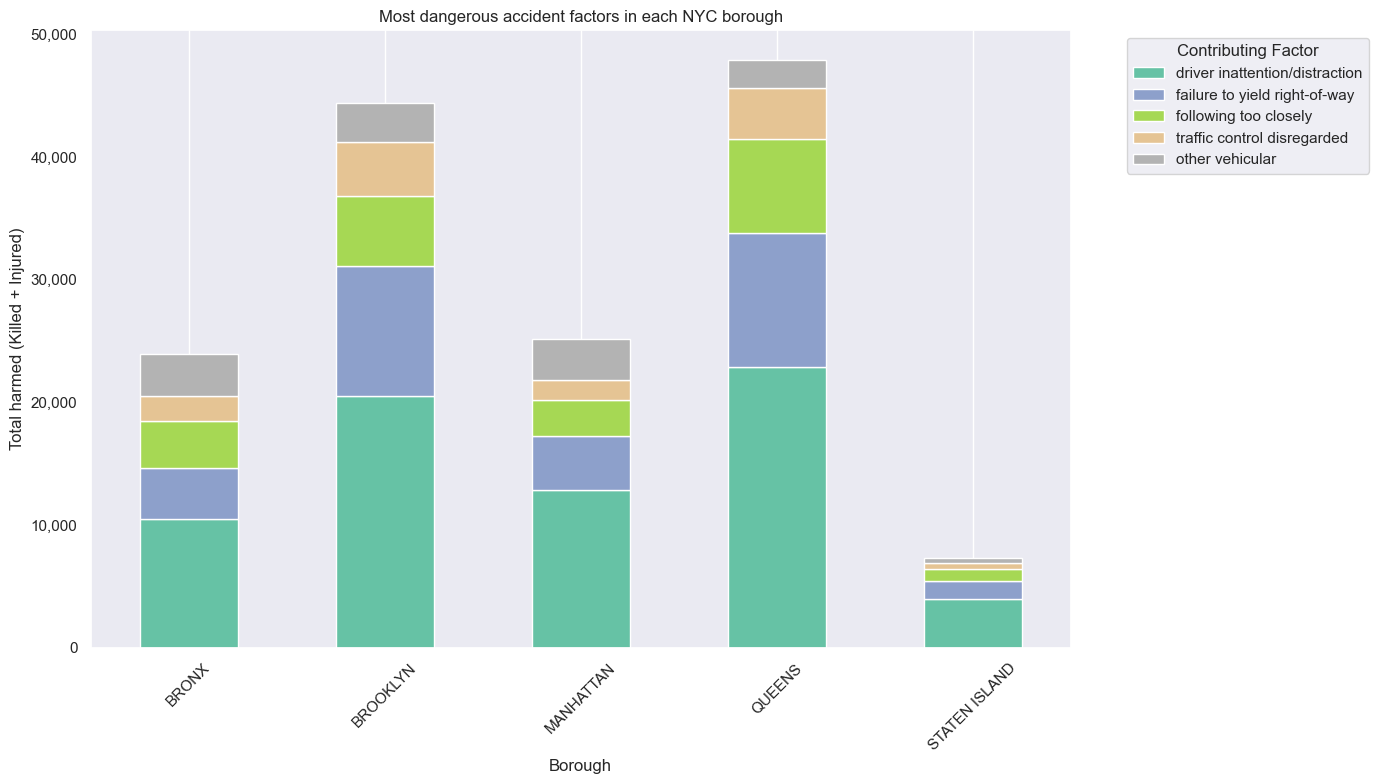

In [224]:
ax = impact_pivot.plot(kind="bar", stacked=True, figsize = (14,8), colormap="Set2")

apply_thousand_separator(ax)

ax.set_title("Most dangerous accident factors in each NYC borough", fontsize=12)
ax.set_xlabel("Borough", fontsize=12)
ax.tick_params(axis = "x",rotation = 45)
ax.set_ylabel("Total harmed (Killed + Injured)")
ax.legend(title="Contributing Factor",bbox_to_anchor=(1.05, 1), loc="upper left")
ax.grid(axis="y")

plt.tight_layout()
plt.savefig("../visuals/01.Most_dangerous_accident_factors_in_each_NYC_borough.png")
plt.show()

# How many deaths and injuries were caused by unsafe speed in each borough

In [225]:
df_speeding = df.copy()

In [226]:
columns = ["BOROUGH","NUMBER OF PERSONS INJURED","NUMBER OF PERSONS KILLED","CONTRIBUTING FACTOR VEHICLE 1",
           "CONTRIBUTING FACTOR VEHICLE 2","CONTRIBUTING FACTOR VEHICLE 3","CONTRIBUTING FACTOR VEHICLE 4", 
           "CONTRIBUTING FACTOR VEHICLE 5", "COLLISION_ID"]

In [227]:
df_speeding = df_speeding[columns]

In [228]:
df_speeding = df_speeding[~df_speeding["BOROUGH"].isin(["UNKNOWN"])]

In [229]:
df_long = df_speeding.melt(id_vars = ["COLLISION_ID","BOROUGH","NUMBER OF PERSONS INJURED", "NUMBER OF PERSONS KILLED"],
                          value_vars = ["CONTRIBUTING FACTOR VEHICLE 1","CONTRIBUTING FACTOR VEHICLE 2","CONTRIBUTING FACTOR VEHICLE 3", 
               "CONTRIBUTING FACTOR VEHICLE 4","CONTRIBUTING FACTOR VEHICLE 5"],
                         var_name="FACTOR_SOURCE",
                         value_name="CONTRIBUTING FACTOR")

In [230]:
df_long = df_long[df_long["CONTRIBUTING FACTOR"].isin(["unsafe speed"])]

In [231]:
summary = df_long.groupby(["BOROUGH"]).agg(
    total_killed = ("NUMBER OF PERSONS KILLED", "sum"),
    total_injured = ("NUMBER OF PERSONS INJURED", "sum")
).reset_index()

In [232]:
print(summary)

         BOROUGH  total_killed  total_injured
0          BRONX            18           1627
1       BROOKLYN            23           2211
2      MANHATTAN            10            750
3         QUEENS            48           2406
4  STATEN ISLAND            12            444


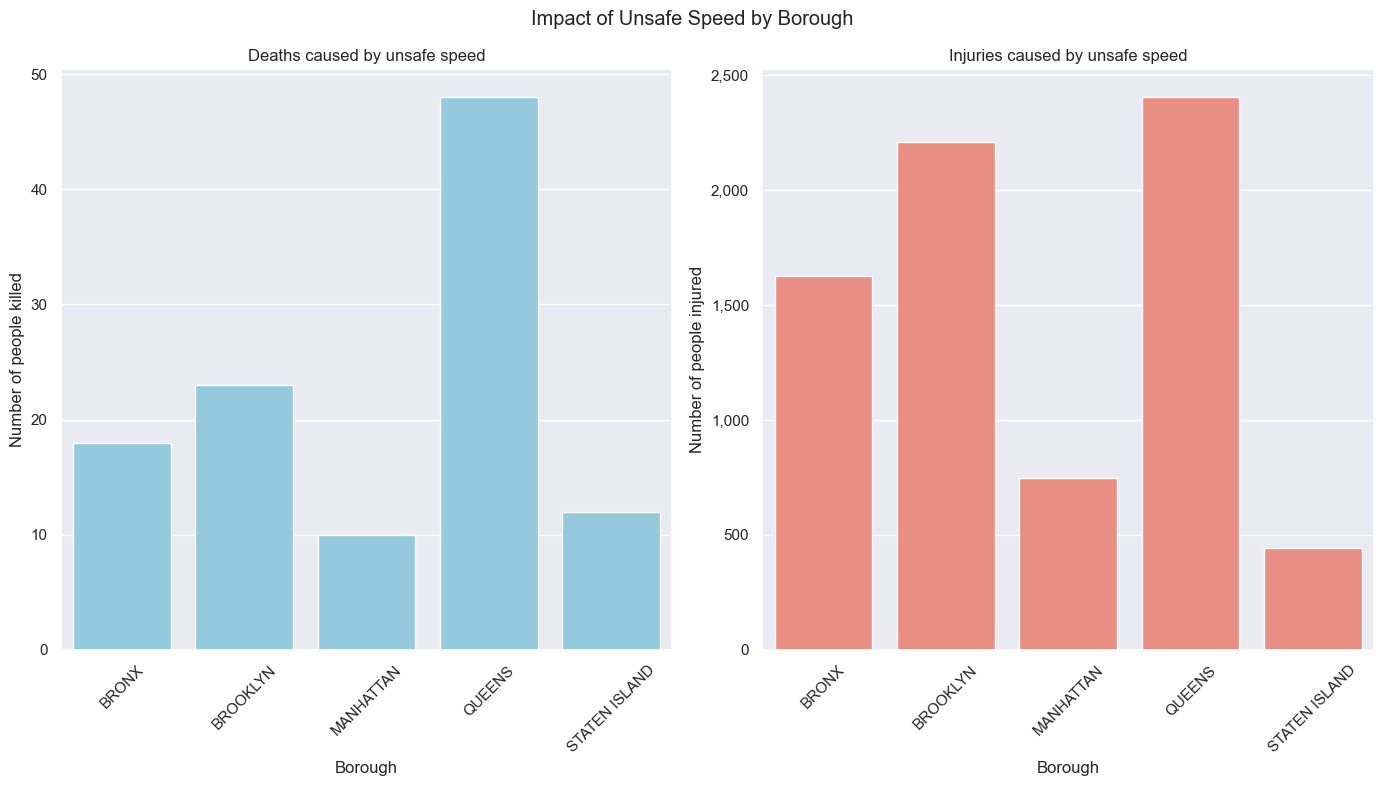

In [233]:
sns.set_style(style="darkgrid")

fig, ax = plt.subplots(1, 2, figsize=(14,8))

sns.barplot(ax = ax[0], data = summary, x = "BOROUGH", y = "total_killed", color = "skyblue")

apply_thousand_separator(ax[0])
apply_thousand_separator(ax[1])

ax[0].set_title("Deaths caused by unsafe speed")
ax[0].set_xlabel("Borough")
ax[0].set_ylabel("Number of people killed")
ax[0].tick_params(axis='x', rotation=45)

sns.barplot(ax=ax[1], data=summary, x="BOROUGH", y="total_injured", color="salmon")
ax[1].set_title("Injuries caused by unsafe speed")
ax[1].set_xlabel("Borough")
ax[1].set_ylabel("Number of people injured")
ax[1].tick_params(axis='x', rotation=45)

plt.suptitle("Impact of Unsafe Speed by Borough")
plt.tight_layout()
plt.savefig("../visuals/02.Impact_of_unsafe_speed_by_borough.png")
plt.show()

# Three most common accident factors broken down by borough and overall for the entire city

In [234]:
df_common_factors = df.copy()

In [235]:
columns = ["BOROUGH","CONTRIBUTING FACTOR VEHICLE 1","CONTRIBUTING FACTOR VEHICLE 2","CONTRIBUTING FACTOR VEHICLE 3","CONTRIBUTING FACTOR VEHICLE 4", 
           "CONTRIBUTING FACTOR VEHICLE 5"]

In [236]:
df_common_factors = df_common_factors[columns]

In [237]:
df_long = df_common_factors.melt(id_vars = ["BOROUGH"],
                                value_vars = ["CONTRIBUTING FACTOR VEHICLE 1","CONTRIBUTING FACTOR VEHICLE 2","CONTRIBUTING FACTOR VEHICLE 3",
                                              "CONTRIBUTING FACTOR VEHICLE 4","CONTRIBUTING FACTOR VEHICLE 5"],
                                 var_name = "FACTOR_SOURCE",
                                 value_name = "CONTRIBUTING FACTOR"
                                )

In [238]:
df_long = df_long[~df_long["CONTRIBUTING FACTOR"].isin(["unknown"])]

In [239]:
df_borough = df_long[
    ~df_long["BOROUGH"].isin(["UNKNOWN"]) &
    ~df_long["CONTRIBUTING FACTOR"].isin(["unknown"])
    ]

In [240]:
top_by_borough = df_borough.groupby(
    ["BOROUGH","CONTRIBUTING FACTOR"]).size().reset_index().rename(columns={0: 'count'}).sort_values(['BOROUGH', 'count'], ascending=[True, False])

In [241]:
top_3_by_borough = top_by_borough.groupby("BOROUGH").head(3)

In [242]:
pivot_borough = top_3_by_borough.pivot(index='BOROUGH', columns='CONTRIBUTING FACTOR', values='count')

In [243]:
top_3_entire = df_long["CONTRIBUTING FACTOR"].value_counts().head(3).reset_index()
top_3_entire.columns = ['CONTRIBUTING FACTOR', 'count']

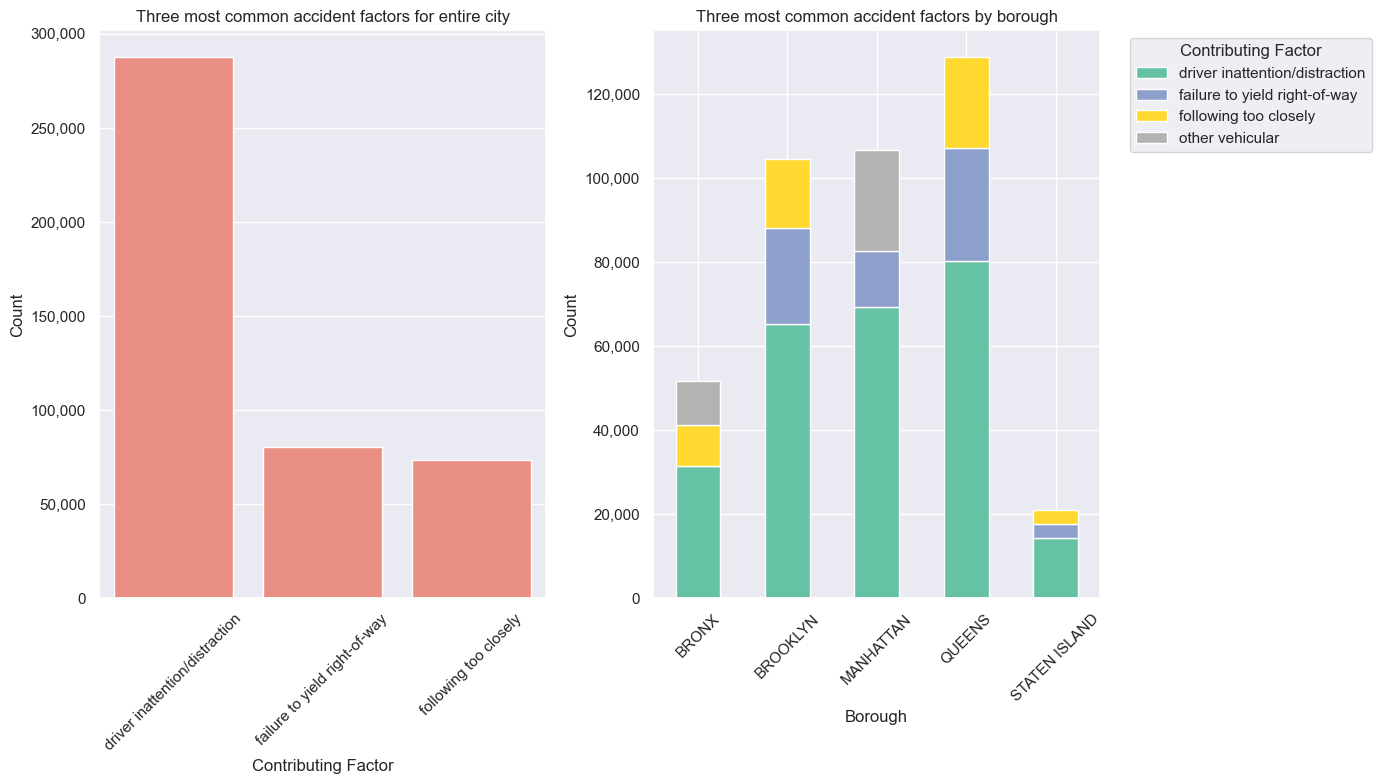

In [244]:
fig, ax = plt.subplots(1,2, figsize=(14,8))

sns.barplot(ax=ax[0], data = top_3_entire, x = "CONTRIBUTING FACTOR", y = "count", color = "salmon"  )

apply_thousand_separator(ax[0])

ax[0].set_title("Three most common accident factors for entire city")
ax[0].set_xlabel("Contributing Factor")
ax[0].tick_params(axis="x", rotation=45)
ax[0].set_ylabel("Count")

ax[1] = pivot_borough.plot(ax=ax[1],kind='bar', stacked=True, colormap='Set2')

apply_thousand_separator(ax[1])

ax[1].set_title("Three most common accident factors by borough")
ax[1].set_xlabel("Borough")
ax[1].set_ylabel("Count")
ax[1].tick_params(axis="x",rotation=45)
ax[1].legend(title="Contributing Factor", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig("../visuals/03.Three_most_common_accident_factors.png")
plt.show()

# Most frequently involved vehicles types in accidents

In [245]:
df_vehicles = df.copy()

In [246]:
vehicle_columns = ["COLLISION_ID", "VEHICLE TYPE CODE 1","VEHICLE TYPE CODE 2","VEHICLE TYPE CODE 3","VEHICLE TYPE CODE 4","VEHICLE TYPE CODE 5"]

In [247]:
df_vehicles = df_vehicles[vehicle_columns]

In [248]:
df_long = df_vehicles.melt(id_vars = ["COLLISION_ID"],
                          value_vars = ["VEHICLE TYPE CODE 1","VEHICLE TYPE CODE 2","VEHICLE TYPE CODE 3","VEHICLE TYPE CODE 4","VEHICLE TYPE CODE 5"],
                          var_name = "TYPE_SOURCE",
                          value_name = "VEHICLE TYPE")

In [249]:
df_long = df_long[~df_long["VEHICLE TYPE"].isin(["unknown"])]

In [250]:
summary = df_long["VEHICLE TYPE"].value_counts().head(5).reset_index()
summary.columns = ["VEHICLE TYPE", "count"]

In [251]:
print(summary)

    VEHICLE TYPE   count
0            car  987036
1            suv  647064
2  taxi / livery  112737
3         pickup   53844
4     motorcycle   39674


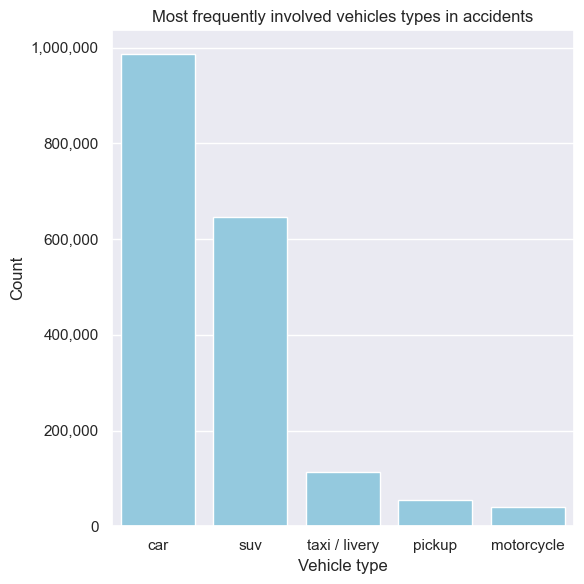

In [252]:
sns.set_theme(rc={'axes.formatter.limits': (-8, 9)})

fig, ax = plt.subplots(figsize=(6, 6))

sns.barplot(data = summary, x = "VEHICLE TYPE", y = "count", color = "skyblue")

apply_thousand_separator(ax)

ax.set_title("Most frequently involved vehicles types in accidents")
ax.set_xlabel("Vehicle type")
ax.set_ylabel("Count")
plt.tight_layout()
plt.savefig("../visuals/04.Most_frequently_involved_vehicle_types.png")
plt.show()

# Statistics on the number of accidents for each borough

In [253]:
df_number = df.copy()

In [254]:
df_number.columns

Index(['ACCIDENT DATE', 'ACCIDENT TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5',
       'ACCIDENT DATE FORMATTED'],
      dtype='object')

In [255]:
columns_statisctics = ["BOROUGH", "ACCIDENT TIME", "COLLISION_ID"]

In [256]:
df_number = df_number[columns_statisctics]

In [257]:
df_number = df_number[~df_number["BOROUGH"].isin(["UNKNOWN"])]

In [258]:
df_number.duplicated().sum()

np.int64(0)

In [259]:
df_number.head()

,BOROUGH,ACCIDENT TIME,COLLISION_ID
0,QUEENS,16:30,4184637
1,BROOKLYN,16:02,4195773
2,MANHATTAN,17:57,4202457
3,BRONX,21:53,4198749
4,MANHATTAN,9:45,4183798


In [260]:
summary_statistics = df_number.groupby(["BOROUGH"]).size().reset_index(name="COUNT").sort_values(by=["COUNT"], ascending=False)

In [261]:
summary_statistics.head()

,BOROUGH,COUNT
1,BROOKLYN,321508
3,QUEENS,310050
2,MANHATTAN,246998
0,BRONX,155334
4,STATEN ISLAND,53648


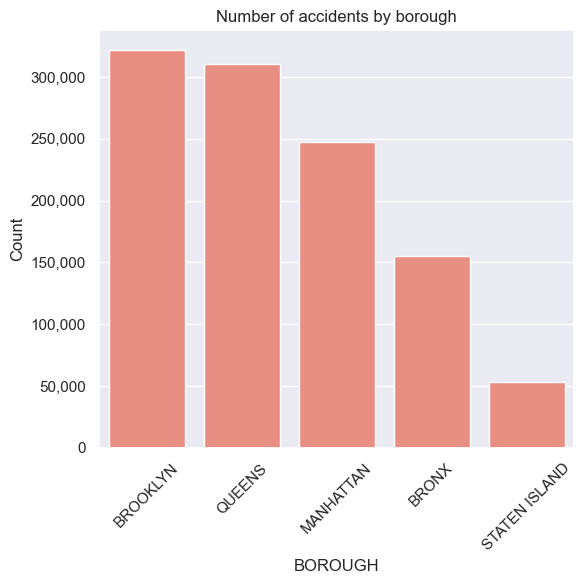

In [262]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.barplot(data = summary_statistics, x = "BOROUGH", y = "COUNT", color = "salmon")

apply_thousand_separator(ax)

ax.set_title("Number of accidents by borough")
ax.set_xlabel("BOROUGH")
ax.set_ylabel("Count")
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.savefig("../visuals/05.Number_of_accidents_by_borough.png")
plt.show()

# Summary

<p>
    In this analysis, I identified the most dangerous contributing factors to traffic accidents by summing the number of people killed and injured. Across all boroughs, the most dangerous factors were <strong>driver inattention/distraction and failure to yield the right-of-way</strong>).</p>
<p>
    Then, I examined the consequences of <strong>unsafe speed</strong>. This factor caused nearly <strong>50 deaths</strong> and approximately <strong>2,400 injuries</strong> in <strong>Queens</strong> alone. In contrast, the fewest fatalities (10) occurred in <strong>Manhattan</strong> and <strong>Staten Island</strong>, where <strong>fewer than 500 people</strong> were injured due to unsafe speed.</p>
<p>
    Followingly, I explored <strong>three most common contributing factors</strong> across the entire city and within each borough. The leading factor for entire city as well as for every borough is <strong>driver inattention/distraction</strong>. The secend most common factor was <strong>failure to yield right-of-way</strong>, except in the <strong>Bronx</strong> where <strong>following too closely</strong> was more prevalent. The third most common factor was also <strong>following too closely</strong>, except in the <strong>Bronx</strong> and <strong>Manhattan</strong>, where <strong>other vehicular</strong> causes ranked third.  
</p>
<p>
    Then, I analyzed the <strong>most frequently involved vehicle types in accidents</strong>. In view of the variety of vehicle types in the given dataset, I decided to generalize them into more broader categories. The most frequent one was <strong>car</strong>, which includes mainly passenger vehicles, sedans and limousines. Vehicles from that category were involved nearly <strong>1,000,000 times</strong>. The second most frequent category was <strong>SUV</strong> involved more than <strong>600,000 times</strong>. <strong>Taxi/livery</strong> vehicles were involved approximately <strong>100,000 times</strong>.
</p>
<p>
    Finally, I examined the <strong>number of accidents by borough</strong>. The highest number occured in <strong>Booklyn</strong>, followed closely by <strong>Queens</strong>—both exceeding <strong>300,000 accidents</strong>. Manhattan reported around <strong>250,000 accidents</strong>, followed by <strong>Bronx</strong> with approximately <strong>150,000</strong>. <strong>Staten Island</strong> had the fewest accidents, with about <strong>50,000</strong>.
</p>
    

# Conslusion